### GRU Model Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load the necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
X = np.load('/content/drive/MyDrive/PrognosAI_OCT25/Data/rolling_window_sequences.npy')
metadata = pd.read_csv('/content/drive/MyDrive/PrognosAI_OCT25/Data/sequence_metadata_with_RUL.csv')
y = metadata['RUL']
print('Features Shape: ',X.shape)
print('Target Shape: ', y.shape)

Features Shape:  (152559, 30, 66)
Target Shape:  (152559,)


In [4]:
# Split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [5]:
# Define GRU model creation function
def create_gru_model(input_shape, units=64, learning_rate=0.001, dropout_rate=0.2):
  model = Sequential()
  model.add(GRU(units, input_shape=input_shape))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1))
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
  return model

In [6]:
# Create the model
model = create_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]), units=64, learning_rate=0.001, dropout_rate=0.2)

# callbacks for early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=35,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/35
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 25715.7676 - mae: 131.7538 - val_loss: 12568.4365 - val_mae: 86.7491
Epoch 2/35
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 10960.2676 - mae: 81.0815 - val_loss: 8091.6240 - val_mae: 69.4543
Epoch 3/35
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 6338.0601 - mae: 58.5555 - val_loss: 4226.5127 - val_mae: 47.2061
Epoch 4/35
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 4179.3911 - mae: 47.4916 - val_loss: 3627.1663 - val_mae: 44.1206
Epoch 5/35
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 3679.9209 - mae: 45.1818 - val_loss: 3461.4041 - val_mae: 43.8591
Epoch 6/35
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 3478.8298 - mae: 44.1472 - val_loss: 3261.0806 - val_mae: 42.8732
Epoch 7/35
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 3250.5842 - mae: 42.8434 - val_loss: 3062.8904 - val_mae: 41.6684
Epoch 8/35
1669/1669 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 3159.4724 - mae: 42.2167 - val

In [8]:
# Evaluate on validation set
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f'Validation MSE: {val_loss:.4f}, MAE: {val_mae:.4f}')

# Predict on test set
y_pred = model.predict(X_val).flatten()

# Calculate test MSE
test_mse = mean_squared_error(y_val, y_pred)
print(f'Test MSE: {test_mse:.4f}')

Validation MSE: 1364.5221, MAE: 27.2808
1431/1431 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Test MSE: 1364.5231


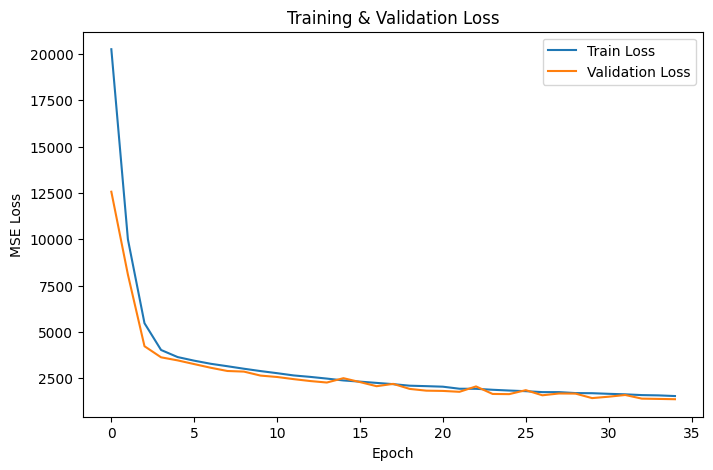

In [9]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

## Observations

The training loss decreases steadily, showing that the model is learning the underlying patterns.

Validation loss follows a similar trend, indicating the model is not overfitting heavily.

A small gap between training and validation losses suggests good generalization.

Any fluctuations in validation loss may indicate sensitivity to learning rate or data noise.

The best performance occurs at the epoch where validation loss is minimal, which is saved by the checkpoint callback.